# Finite responses ORA

**Computes the adjusted p-value (or Q-value) for GOBP terms as a function of the number of responses.**

In [1]:
import os
from json import dumps
import logging
import pandas as pd
import numpy as np
import math
import json
from tqdm.notebook import tqdm

from scipy.stats import hypergeom as hg

import matplotlib.pyplot as plt
from matplotlib import cm

#from scipy.stats import hypergeom as hg
import statsmodels.stats as sts

from CoRe import reader, fnGO
from multipy.fdr import qvalue

import random as rand

In [2]:
def sample_set(dropout_dict):
    selected_set = []
    
    for gene in dropout_dict.keys():
        xi = rand.uniform(1,0)
        
        if xi>dropout_dict[gene]:
            selected_set.append(gene)
            
    selected_set = pd.DataFrame(selected_set,columns=None)
            
    return selected_set

**Read the gene sets and determine the list of unique genes.**

In [3]:
go_directory = "/Users/swarnavo/Research/Reactome-Graph-Database/HumanData/GO_enrichment/GO_sets"
os.chdir(go_directory)

f = open(('GO_BPs.json'))
GO_BPs = json.load(f)
f.close()

for bp in GO_BPs.keys():
    GO_BPs[bp] = pd.DataFrame(GO_BPs[bp])

total_gene_set = pd.read_csv('all_unique_genes.csv',header=None)[0].to_list()
total_genes = len(total_gene_set)

print('Total gene sets: ',len(list(GO_BPs.keys())))
print('Total unique genes: ',total_genes)

Total gene sets:  7481
Total unique genes:  17949


**Read the names of minimal genes sets, or gene sets that do no contain other gene sets.**

In [4]:
data_directory = "/Users/swarnavo/Research/Reactome-Graph-Database/HumanData/GO_enrichment"
os.chdir(data_directory)

minimum_GOBP = pd.read_csv('minimum_BP_set.csv',header=None)[0].to_list()

Read the set of genes that have direct protein-protein interactions with SARS-CoV-2 proteins, and read the set of gene that are both directly interacting or indirectly receiving information about the SARS-CoV-2 proteins.

In [5]:
selected_pathway = 'Immune System'
pathway_nametag = selected_pathway.replace(' ','_')

network_type = 'medium-PPI'
network_label = 'medium'
state_type = 'maxEnt'

data_directory = "/Users/swarnavo/Research/Reactome-Graph-Database/HumanData/"+pathway_nametag
os.chdir(data_directory)

#direct_interaction_set = reader.read_interactions_for_GO('SARS_CoV2-'+pathway_nametag+'_'+network_type+'_interactions.csv')
#total_interaction_set = reader.read_interactions_for_GO('SARS_CoV2_total_'+pathway_nametag+'_'+network_type+'_interactions.csv')

direct_interaction_set = reader.read_interactions_for_GO('SARS_CoV2-'+pathway_nametag+'_interactions.json')
#direct_interaction_set = reader.read_interactions_for_GO('SARS_CoV2-'+pathway_nametag+'_'+network_type+'_interactions.json')

In [8]:
f = open('maxEnt-all_nontrivial_gos-H.json')
all_nontrivial_gos = json.load(f)
f.close()

all_nontrivial_go_tags = {}

for sp in all_nontrivial_gos.keys():
    all_nontrivial_go_tags[sp] = []
    
    for go in all_nontrivial_gos[sp]:
        all_nontrivial_go_tags[sp].append('GOBP_'+go.replace(' ','_'))

In [9]:
f = open('maxEnt-all_p_gos-H.json')
all_p_gos = json.load(f)
f.close()

all_p_go_names = {}

for sp in all_p_gos.keys():
    all_p_go_names[sp] = []
    
    for go in all_p_gos[sp]:
        all_p_go_names[sp].append(go.replace('_',' ').replace('GOBP ',''))

In [10]:
all_unique_gos = pd.read_csv(state_type+'-all_unique_go_names-H.csv',header=None)[0].to_list()
go_tag = ['GOBP_'+s.replace(' ','_') for s in all_unique_gos]

In [11]:
communicated_set = pd.read_csv(state_type+'-SARS_CoV2_'+pathway_nametag+'_'+network_type+'_affected_genes0.0.csv')

print(communicated_set.shape)
print(list(communicated_set)[2:])

(91, 13)
['SARS-CoV2 Nsp2', 'SARS-CoV2 Nsp7', 'SARS-CoV2 Nsp12', 'SARS-CoV2 Nsp13', 'SARS-CoV2 Nsp14', 'SARS-CoV2 ORF3a', 'SARS-CoV2 M', 'SARS-CoV2 ORF8', 'SARS-CoV2 ORF9b', 'SARS-CoV2 ORF9c', 'SARS-CoV2 ORF10']


In [12]:
N = 1000

dropout_prob = {}

for sp in list(communicated_set)[2:]:
    dropout_prob[sp] = {}
    
    for i in range(0,communicated_set.shape[0]):
        if communicated_set[sp][i]>0.0:
            prob = 2**(-N*communicated_set[sp][i])
            
            if prob>=1e-5:
                dropout_prob[sp][communicated_set['node_ids'][i]] = prob
            else:
                dropout_prob[sp][communicated_set['node_ids'][i]] = 0.0

In [13]:
for sp in dropout_prob.keys():
    for g in direct_interaction_set[sp][0].to_list():
        dropout_prob[sp][g] = 0.0

In [14]:
print('Factor \t Direct interaction \t Direct + communicated interactions')

sources = []

for sp in dropout_prob.keys():
    if len(communicated_set[sp])>len(direct_interaction_set[sp]):# or 'Nsp2' in sp) and 'ORF10' not in sp:
        sources.append(sp)
        
        print(sp,'\t',len(direct_interaction_set[sp][0].to_list()),len(dropout_prob[sp].keys()))

Factor 	 Direct interaction 	 Direct + communicated interactions
SARS-CoV2 Nsp2 	 2 3
SARS-CoV2 Nsp7 	 9 28
SARS-CoV2 Nsp12 	 1 7
SARS-CoV2 Nsp13 	 1 3
SARS-CoV2 Nsp14 	 2 7
SARS-CoV2 ORF3a 	 1 2
SARS-CoV2 M 	 2 33
SARS-CoV2 ORF8 	 7 46
SARS-CoV2 ORF9b 	 1 3
SARS-CoV2 ORF9c 	 2 5
SARS-CoV2 ORF10 	 2 4


Identify the sources, or SARS-CoV-2 proteins, that are causing communication. We determine this if for a SARS-CoV-2 protein the number of affected genes is greater than the number of genes that have PPI.

In [15]:
go_names, p_values = {}, {}

In [16]:
n_samples = 40000

for sp in tqdm(dropout_prob.keys()):
    go_names[sp] = all_nontrivial_gos[sp]
    #go_names[sp] = all_p_gos[sp]
    p_values[sp] = np.zeros(shape=(len(go_names[sp]),))
    
    actual_samples = 0
    
    for n in range(0,n_samples):
        sp_set = sample_set(dropout_prob[sp])
        
        #sp_set = pd.DataFrame(list(dropout_prob[sp].keys()),columns=None)
        len_interaction = int(sp_set[0].count())
        
        for go_idx in range(0,len(go_names[sp])):
            go = all_nontrivial_go_tags[sp][go_idx]
            #go = all_p_gos[sp][go_idx]
            
            intersection = pd.merge(GO_BPs[go], sp_set, how='inner').drop_duplicates([0])
            len_intersection = int(intersection[0].count())
            len_gene_BP = int(GO_BPs[go].count())
            
            if len_intersection>0:
                pvalue = hg.sf(len_intersection-1, total_genes, len_gene_BP, len_interaction)
                p_values[sp][go_idx] += pvalue 
                actual_samples += 1
            else:
                p_values[sp][go_idx] += 1
    
    for go_idx in range(0,len(go_names[sp])):
        #p_values[sp][go_idx] *= 1.0/float(actual_samples)
        p_values[sp][go_idx] *= 1.0/float(n_samples)
        

  0%|          | 0/11 [00:00<?, ?it/s]

Correct for multiple hypothesis testing.

sources = list(dropout_prob.keys())
print(sources)

for s in sources:
    print(np.sum(p_values[s]))

In [17]:
sources = []

for sn in list(dropout_prob.keys()):
    if np.sum(p_values[sn])>0:
        sources.append(sn)

In [18]:
q_values = {}
go_tags = {}

for s_g in sources:
    go_tags[s_g], go_names[s_g], q_values[s_g] = fnGO.compute_q_values(p_values[s_g],go_names[s_g],all_nontrivial_go_tags[s_g],0.01,return_all=True)

Specify a cutoff q-value to determine the over-represented biological processes. Also, specify the top $n$ processes to select for each SARS-CoV-2 protein.

In [20]:
cutoff = 0.01

selected_gos = pd.read_csv('high-selected_gos-hierarchical.csv',header=None)[0].to_list()

In [21]:
total_q = (-math.log10(1))*np.ones(shape=(len(selected_gos),len(sources)))
q_matrix = np.zeros(shape=(len(selected_gos),len(sources)))

for i in range(0,len(selected_gos)):
    for j in range(0,len(sources)):
        s_g = sources[j]
        
        try:
            k = go_names[s_g].index(selected_gos[i])
            
            if q_values[s_g][k]<cutoff:         
                total_q[i,j] = -math.log10(max(q_values[s_g][k],1e-10))
            #else:
            #    total_q[i,j] = 1.0
            
            q_matrix[i,j] = q_values[s_g][k]
                
        except ValueError:
            pass

short_sars = []

for s in sources:
    short_sars.append(s.split(' ')[1])

In [22]:
c_max = min(np.max(total_q),10.0)
print(c_max)

r = c_max + math.log10(cutoff)
c_min = -math.log10(cutoff) - r

print(np.min(total_q))

print(c_max,c_min,r)

pixel_width = 0.5

l = pixel_width*len(selected_gos)
w = 0.9*pixel_width*len(short_sars)

10.0
-0.0
10.0 -6.0 8.0


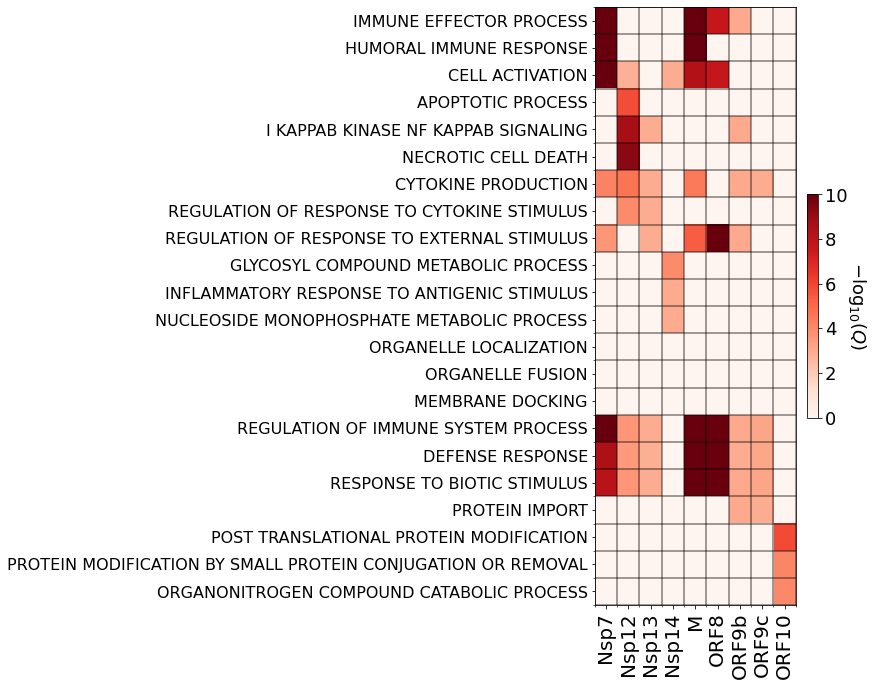

In [23]:
fig, ax = plt.subplots(figsize=(4,11))

plt.imshow(total_q,cmap=cm.Reds,aspect='auto',vmin=0,vmax=10)
cbar = plt.colorbar(fraction=0.05,pad=0.05)

ax.set_xticks(np.arange(0,len(short_sars)))
ax.set_xticklabels(short_sars,fontsize=20,rotation=90)

ax.set_yticks(np.arange(0,len(selected_gos)))
ax.set_yticklabels(selected_gos,fontsize=16)

cbar.set_label(r'$-\log_{10}$($Q$)',fontsize=18,rotation=-90,labelpad=20)
cbar.ax.tick_params(labelsize=18)

ax.set_xticks(np.arange(-.5, len(short_sars), 1), minor=True)
ax.set_yticks(np.arange(-.5, len(selected_gos), 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=1.5, alpha=0.5)

In [24]:
q_data = pd.DataFrame(q_matrix,columns=sources,index=None)

q_data.insert(0,"GOBP",selected_gos)

q_data.to_csv(state_type+'-q_data'+str(N)+'.csv',index=None)